<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week6/keras_simple_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras MLP: Step-by-step Training on a Simple Example (Breast Cancer Dataset)

In this notebook, we will walk through the process of training a **Multilayer Perceptron (MLP)** using **Keras** on a well-known example dataset: the **Breast Cancer Wisconsin Diagnostic dataset**.

This is a great starting point for learning about neural networks and classification tasks with tabular data.

---

### Breast Cancer Dataset Overview

- A classical **binary classification** dataset.
- Contains **569 samples** and **30 input features** (real-valued, positive).
- The **target** variable indicates whether the tumor is **malignant** (0) or **benign** (1).
- All features are computed from digitized images of a breast mass.

You can find the dataset here:
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)
- [Scikit-learn's built-in loader](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)

We will use the version included in **scikit-learn**, which is preprocessed and ready to use.

---

### More Datasets for Practice

If you're interested in more classical machine learning datasets (classification, regression, clustering...), check out:

👉 [Scikit-learn toy datasets overview](https://scikit-learn.org/stable/api/sklearn.datasets.html)

These are great for experimenting and building intuition before moving to real-world data.

---

### Machine Learning Workflow
1. Process the data

  1.1. Load, observe and analyze the data

  1.2. Clean and preprocess the data
2. Define the model

  2.1. Define the model architecture (type of the model, number of layers, activation functions)

  2.2. Set model hyperparameters (learning rate, batch size, optimizer, loss function,...)
3. Train the model

  3.1. Observe and analyze the training progress

4. Evaluate the model and make prediction

   4.1. Assess model performance on training, validation and test data
   
   4.2. Use the trained model to predict on new unseen data

## 1. Process the data
1.1. Load, observe and analyze the data
 - Use `scikit-learn` to load the dataset.
 - Display basic info: number of samples, number of features, class distribution.
 - Visualize some features if needed.



In [75]:
from sklearn.datasets import load_breast_cancer
import numpy as np

# Load and observe the data:
cancer = load_breast_cancer()  # 'cancer' is a dictionary-like object (sklearn.utils.Bunch)
# It contains: data, target, feature names, target names, description, etc.
print(cancer.keys())

# Observe shape:
print("Input data shape:", cancer['data'].shape)
print("Target data shape:", cancer['target'].shape, "\n")

# Analyze the label distribution:
print("Target names:", cancer['target_names'])
print("Target distribution:", np.bincount(cancer['target']))
print("  malignant (0):", np.bincount(cancer['target'])[0])
print("  benign    (1):", np.bincount(cancer['target'])[1], "\n")

# Observe input data:
print("Feature names:", cancer['feature_names'] )
print("Minimum, mean and maximum input data values: ", np.min(cancer['data']), np.mean(cancer['data']), np.max(cancer['data']))
#print("Feature means:", np.mean(cancer['data'], axis=0))
#print("Feature description:", cancer['DESCR'])  # description of the data
print()

# Check for missing values
print("Number of missing values in the data:", np.sum(np.isnan(cancer['data'])))
print("Number of missing values in the labels:", np.sum(np.isnan(cancer['target'])))
print()

import pandas as pd
df = pd.DataFrame(cancer['data'], columns=cancer['feature_names']) # Create a Pandas DataFrame for easier analysis
#print(df.describe())                                              # Calculate statistics for each column
#print(df.info())                                                  # Check data types and non-null counts
print(df.head())                                                   # Display the first few rows of the DataFrame

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
Input data shape: (569, 30)
Target data shape: (569,) 

Target names: ['malignant' 'benign']
Target distribution: [212 357]
  malignant (0): 212
  benign    (1): 357 

Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Minimum, mean and maximum input data values:  0.0 61.890712339519624 4254.0

Number of missing values in the data: 0
Number of missing values in the label

1.2. Clean and preprocess the data
- Normalize or standardize the input features (important for multilayer neural networks).
- Split the data into **training**, **validation**, and **test** sets.

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X, y = cancer.data, cancer.target

# Preprocess the data:
# 1. Reshape (vectorize) the input data to have the shape (number of samlples, number of features) ... Already in correct format
# 2. Convert the data into floating-point numbers ... Already in correct format
# 3. Resolve missing values, incorrect values... not needed (data is clean)
# 4. One-hot encode the labels (for multi-class problems)... not needed (binary classification)
#       y_train_categorical = keras.utils.to_categorical(y_train, num_classes=10) ... to one-hot encoding
# 5. Data augmentation,...

# 6. Split the dataset - into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 7. Normalize the features to improve training stability
# - StandardScaler: Centers data around zero and scales to unit variance
# - MinMaxScaler: Scales features to a given range (default [0,1], here [-1,1])
scaler = StandardScaler()
#scaler = MinMaxScaler(feature_range=(-1, 1)) # alternative option
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


## 2. Define and train the model in Keras


### 2.1. Define the model architecture
- the **type** of the model (Sequential,  Functional or Subclassing API)
- the **number and type of the layers**
- The **number of units (neurons)** in each layer
- The **activation functions** used in each layer

Keras supports three main ways to define models:

1. **Sequential API** – simple, stack-like models  
2. **Functional API** – more flexible; supports branching, multiple inputs/outputs  
3. **Model Subclassing (object-oriented API)** – maximum control; define custom logic using Python classes

In this notebook, we'll use the Sequential API, which is the easiest and most readable option for simple sequential neural networks.

### How to set architecture of a MLP model for binary classification?
- Use fully connected (**Dense**) layers.
    - we an change the initialization method for weights and biases
- Activations:
    - 'sigmoid' activation function in the output layer
    - 'relu' or 'tanh' in the hidden layers
- The **number of layers and neurons** is usually determined **experimentally** (through hyperparameter tuning).

In [77]:
# we can set Keras backend to PyTorch (default: 'tensorflow')
import os
os.environ["KERAS_BACKEND"] = "torch"  # "tensorflow" "jax", "torch"

import keras

In [78]:
import keras
from keras import layers


model = keras.Sequential([
    layers.InputLayer(shape=(X_train.shape[1],)),  # Input Layer
    #layers.Dense(30, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros') # First hidden layer
    layers.Dense(30, activation='relu'), # First hidden layer
    layers.Dense(15, activation='relu'),  # Second hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_51 (Dense)                     │ (None, 30)                  │             930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 15)                  │             465 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,411 (5.51 KB)

 Trainable params: 1,411 (5.51 KB)

 Non-trainable params: 0 (0.00 B)

### 2.2 Set Hyperparameters
- **Loss function:** 'binary_crossentropy' (for binary classification)

- **Evaluation Metrics:** 'Accuracy', 'Precision', 'Recall', 'F1-score', ... (for classification)
- **Optimizer:** `adam`, `sgd`, `rmsprop`, `adagrad`, etc.
- set **parameters of the optimizer** (e.g., learning rate,...)
```python
keras.optimizers.Adam(learning_rate=0.001, momentum=0.9)
```



In [79]:
# Define optimizer with custom learning rate and other parameters
optimizer = keras.optimizers.SGD(learning_rate=0.01)

# Configure the model:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[ 'accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])

- we can use **compile()** to re-initialize the model again

## 3. Train the model

- **batch size:** 16, 32, 64, 128, 256
    - Smaller = slower training, possibly better generalization
    - Larger = faster training, but may converge poorly
- **number of epochs:** Typically determined experimentally, with help of:

    - validation accuracy,
    - early stopping
    - overfitting analysis

In [80]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4027 - loss: 0.7186 - precision: 0.5438 - recall: 0.1007 - val_accuracy: 0.5165 - val_loss: 0.6299 - val_precision: 0.8235 - val_recall: 0.2545
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5636 - loss: 0.6439 - precision: 0.9061 - recall: 0.3241 - val_accuracy: 0.7473 - val_loss: 0.5642 - val_precision: 0.9706 - val_recall: 0.6000
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7655 - loss: 0.5496 - precision: 0.9756 - recall: 0.6289 - val_accuracy: 0.8352 - val_loss: 0.5080 - val_precision: 0.9348 - val_recall: 0.7818
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8564 - loss: 0.4935 - precision: 0.9895 - recall: 0.7816 - val_accuracy: 0.8901 - val_loss: 0.4555 - val_precision: 0.9245 - val_recall: 0.8909
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9239 - loss: 0.4098 - precision: 0.9801 - recall: 0.8980 - val_accuracy: 0.9231 - val_loss: 0.4067 - val

- The `fit` method returns the training record as a `History` object.
- You can access the recorded loss and metrics for each epoch via `history.history`.
- This is useful for plotting learning curves or analyzing model performance over time.

In [81]:
# Training record:
print(history.history.keys())

print("Loss (binary_crossentropy): ", history.history['loss'][:10])
print("Accuracy:", history.history['accuracy'][:10])
print("Precision:", history.history['precision'][:10])
print("Recall:", history.history['recall'][:10])


dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])
Loss (binary_crossentropy):  [0.6996863484382629, 0.6071742177009583, 0.5399619936943054, 0.4795626103878021, 0.4226580262184143, 0.3701225519180298, 0.32571887969970703, 0.2896493375301361, 0.25949227809906006, 0.23497752845287323]
Accuracy: [0.40934064984321594, 0.6043956279754639, 0.7829670310020447, 0.8708791136741638, 0.906593382358551, 0.9450549483299255, 0.9450549483299255, 0.9450549483299255, 0.9450549483299255, 0.9450549483299255]
Precision: [0.6818181872367859, 0.9578947424888611, 0.9691358208656311, 0.9693877696990967, 0.9712918400764465, 0.9647576808929443, 0.9567099809646606, 0.9567099809646606, 0.9567099809646606, 0.9567099809646606]
Recall: [0.12987013161182404, 0.39393940567970276, 0.6796537041664124, 0.822510838508606, 0.8787878751754761, 0.948051929473877, 0.9567099809646606, 0.9567099809646606, 0.9567099809646606, 0.9567099809646606]


- Visualize the training progress:

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])


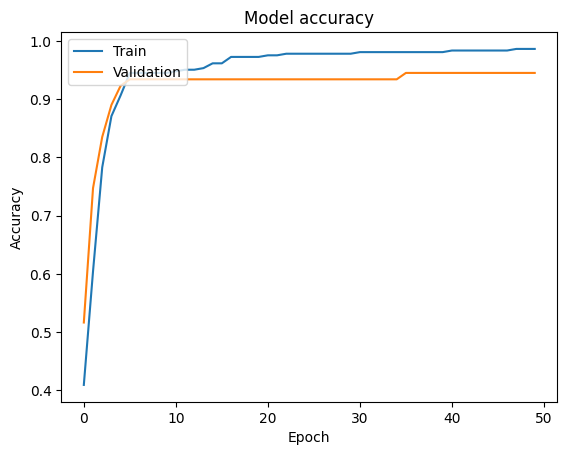

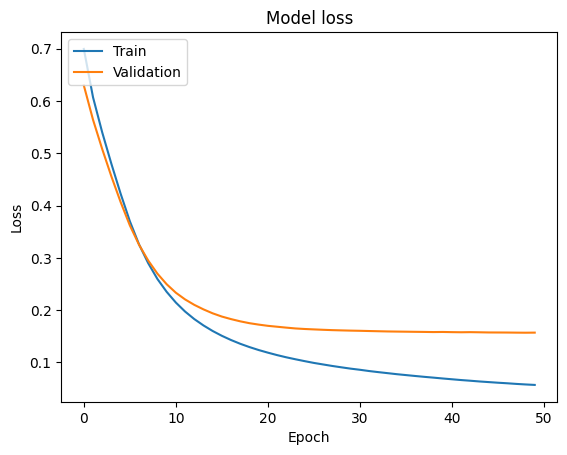

In [82]:
# plot the training progress:
history_dict = history.history
print(history_dict.keys())

from matplotlib import pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



### 3.1  Callbacks to monitor and control the training process

Callbacks are tools that allow you to intervene at specific stages of model training.

They can help you:
- Stop training early if the model stops improving (`EarlyStopping`)
- Save the best version of the model during training (`ModelCheckpoint`)
- Adjust the learning rate dynamically (`ReduceLROnPlateau`)
- Log training progress for visualization (`TensorBoard`)

Below is an example using `EarlyStopping` to stop training if the validation loss doesn't improve for a number of epochs.

In [83]:
model = keras.Sequential([
    layers.InputLayer(shape=(X_train.shape[1],)),  # Input Layer
    #layers.Dense(30, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros') # First hidden layer
    layers.Dense(30, activation='relu'), # First hidden layer
    layers.Dense(15, activation='relu'),  # Second hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Define optimizer with custom learning rate and other parameters
optimizer = keras.optimizers.SGD(learning_rate=0.01)

# Configure the model:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[ 'accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])


# Early stopping:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=300, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4555 - loss: 0.7095 - precision: 0.5305 - recall: 0.6526 - val_accuracy: 0.5824 - val_loss: 0.6725 - val_precision: 0.6049 - val_recall: 0.8909
Epoch 2/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7266 - loss: 0.6424 - precision: 0.7150 - recall: 0.9406 - val_accuracy: 0.6923 - val_loss: 0.6184 - val_precision: 0.6753 - val_recall: 0.9455
Epoch 3/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7504 - loss: 0.5985 - precision: 0.6990 - recall: 0.9989 - val_accuracy: 0.7802 - val_loss: 0.5649 - val_precision: 0.7397 - val_recall: 0.9818
Epoch 4/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8020 - loss: 0.5314 - precision: 0.7606 - recall: 0.9902 - val_accuracy: 0.8352 - val_loss: 0.5121 - val_precision: 0.7941 - val_recall: 0.9818
Epoch 5/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8605 - loss: 0.4593 - precision: 0.8298 - recall: 0.9887 - val_accuracy: 0.8681 - val_loss: 0.

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])


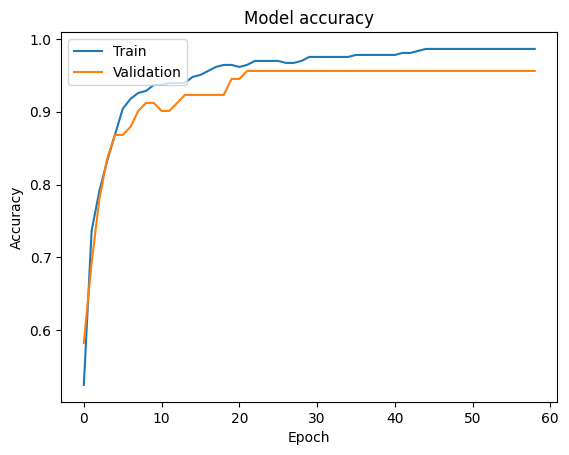

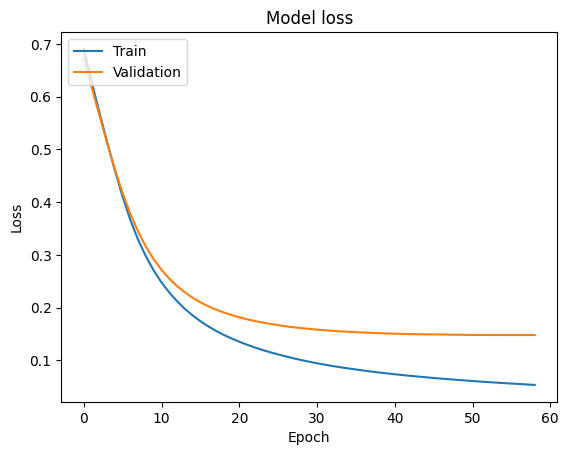

In [84]:
# plot the training progress:
history_dict = history.history
print(history_dict.keys())

from matplotlib import pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 4. Evaluate the model and make predictions




###   4.1. Assess model performance on training, validation and test data

In [85]:
##########################################################################
# 5. Evaluate the model and make predictions
# 5a. Evaluate the model on the train, validation and test sets
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test)
train_loss, train_acc, train_precision, train_recall = model.evaluate(X_train, y_train)
val_loss, val_acc, val_precision, val_recall = model.evaluate(X_val, y_val)

# Print evaluation metrics:
print(f"Train Accuracy:      {train_acc:.4f} | Train Loss:      {train_loss:.4f} | Train Precision:      {train_precision:.4f} | Train Recall:      {train_recall:.4f}")
print(f"Validation Accuracy: {val_acc:.4f} | Validation Loss: {val_loss:.4f} | Validation Precision: {val_precision:.4f} | Validation Recall: {val_recall:.4f}")
print(f"Test Accuracy:       {test_acc:.4f} | Test Loss:       {test_loss:.4f} | Test Precision:       {test_precision:.4f} | Test Recall:       {test_recall:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9578 - loss: 0.0963 - precision: 0.9762 - recall: 0.9573
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9863 - loss: 0.0521 - precision: 0.9939 - recall: 0.9849
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9624 - loss: 0.1124 - precision: 0.9669 - recall: 0.9722
Train Accuracy:      0.9863 | Train Loss:      0.0548 | Train Precision:      0.9871 | Train Recall:      0.9913
Validation Accuracy: 0.9560 | Validation Loss: 0.1477 | Validation Precision: 0.9474 | Validation Recall: 0.9818
Test Accuracy:       0.9649 | Test Loss:       0.0836 | Test Precision:       0.9855 | Test Recall:       0.9577


 ### 4.2. Use the trained model to predict on new unseen data

In [86]:
# Make predictions on test data
probabilities = model.predict(X_test)

# Predicted class:
predictions = np.round(probabilities)

# Misclassified indices:
misclassified_indices = np.where(predictions.flatten() != y_test)[0]

print("Probabilities:", np.round(probabilities[:5].flatten(), 5))
print("Predictions:", predictions[:5].flatten().astype(int))
print("True labels:", y_test[:5])
print("Number of misclassified samples:", np.sum(predictions.flatten() != y_test), "out of", len(y_test))
print("Indices of misclassified samples:", misclassified_indices)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Probabilities: [9.0497e-01 5.7000e-04 3.8240e-02 9.8942e-01 9.9911e-01]
Predictions: [1 0 0 1 1]
True labels: [1 0 0 1 1]
Number of misclassified samples: 4 out of 114
Indices of misclassified samples: [  8  20  52 112]


- Compute and observe the Confusion matrix:

[[42  1]
 [ 3 68]]


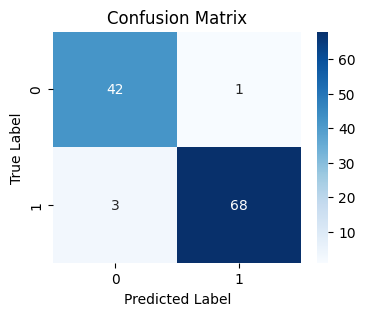

In [87]:
# Confusion matrix:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
print(cm)


# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



## Save the model (and load it again)


In [88]:
import os
import datetime
model_dir = "./models/"

# ensure the directory exists:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the model (and load it again)
model_name = model_dir + "model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.keras'
model.save(model_name)




In [89]:
# Load the model
loaded_model = keras.models.load_model(model_name)

# Evaluate the loaded model
loss, acc, prec, recall = loaded_model.evaluate(X_test, y_test)
loss, acc, prec, recall



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9578 - loss: 0.0963 - precision: 0.9762 - recall: 0.9573


(0.08364164084196091,
 0.9649122953414917,
 0.9855072498321533,
 0.9577465057373047)

# The code in one cell:

# TensorBoard


### Exercises

- Change the number of layers and neurons in the model. Observe how this affects the model's accuracy. You can also experiment with different activation functions in the hidden layers (e.g., tanh).
- Experiment with the number of epochs and learning rate. Plot the learning curves to see the differences.
- Change the loss function. Try using a different loss function, such as mean_squared.
- Experiment with different batch sizes. Observe how different batch sizes during training affect the model's accuracy and training time.
- Try an alternative normalization method for the input data (e.g., standardization). See how this affects the model's performance.
- Investigate the confusion matrix.
- Try changing the optimizer used in the model. Experiment with optimizers such as Adam, RMSprop, or Adagrad, and observe how they affect accuracy and training time.
- Use TensorBoard. Set up TensorBoard to visualize your model’s performance, learning curves, and other metrics in real-time. This will help you track your experiments and analyze results more effectively during training.

